In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io import loadmat
from scipy.signal import spectrogram

In [2]:
erp_mat = loadmat('ERP_data.mat')
erp_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Properties', 'Markers', 'EEGData', 'EEGPosition', 'EEGPoints', 'EEGChannelList', 'ep', 'EEGTime', 'FileName', 'NodeName', 'Analyzer', 'fname', 'pname', 'EEGSegments'])

In [75]:
trials = erp_mat['EEGData'].shape[2]
dlength = erp_mat['EEGData'].shape[0]
erp_arr = np.zeros([trials, dlength])

for t in range(trials):
    erp_arr[t, :] = erp_mat['EEGData'][:, 0, t]

erp = np.mean(erp_arr, axis=0)

fs = 1024 # 1 / np.diff(erp_mat['EEGTime'].ravel())[0]
erp_N = erp.shape[0]
erp_time = np.linspace(0, erp_N / fs, erp_N, endpoint=False) # erp_mat['EEGTime'].ravel()

In [65]:
ssvep_mat = loadmat('SSVEP_data.mat')
ssvep_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Properties', 'Markers', 'EEGData', 'EEGPosition', 'EEGPoints', 'EEGChannelList', 'ep', 'EEGTime', 'FileName', 'NodeName', 'Analyzer', 'fname', 'pname', 'EEGSegments'])

In [76]:
trials = ssvep_mat['EEGData'].shape[2]
dlength = ssvep_mat['EEGData'].shape[0]
ssvep_arr = np.zeros([trials, dlength])

for t in range(trials):
    ssvep_arr[t, :] = ssvep_mat['EEGData'][:, 0, t]

ssvep = np.mean(ssvep_arr, axis=0)

fs = 1024 # 1 / np.diff(ssvep_mat['EEGTime'].ravel())[0]
ssvep_N = ssvep.shape[0]
ssvep_time = np.linspace(0, ssvep_N / fs, ssvep_N, endpoint=False) # ssvep_mat['EEGTime'].ravel()

ValueError: x and y must have same first dimension, but have shapes (1792,) and (614,)

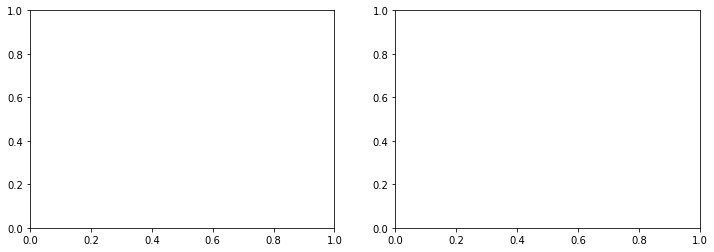

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(erp_time, erp)
ax[1].plot(ssvep_time, ssvep)

ax[0].set_title('ERP data')
ax[0].set_xlabel('Tiempo [s]')
ax[0].set_ylabel('Amplitud')

ax[1].set_title('SSVEP data')
ax[1].set_xlabel('Tiempo [s]')
ax[1].set_ylabel('Amplitud')

# AGREGAR PROMEDIACIÓN ORDENADA Y PONDERADA RESPECTIVAMENTE

Text(0.5, 0, 'Amplitud')

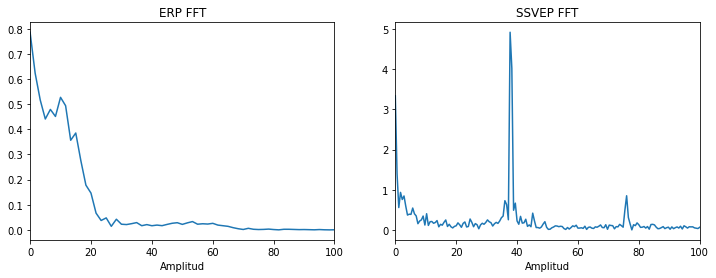

In [83]:
erp_fft = fft(erp)[:erp_N // 2]
erp_ff = fftfreq(erp_N, 1 / fs)[:erp_N // 2]

ssvep_fft = fft(ssvep)[:ssvep_N // 2]
ssvep_ff = fftfreq(ssvep_N, 1 / fs)[:ssvep_N // 2]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(erp_ff, 2 / fs * np.abs(erp_fft))
ax[0].set_xlim([0, 100])

ax[0].set_title('ERP FFT')
ax[0].set_xlabel('Frecuencia [hz]')
ax[0].set_ylabel('Amplitud')

ax[1].plot(ssvep_ff, 2 / fs * np.abs(ssvep_fft))
ax[1].set_xlim([0, 100])

ax[1].set_title('SSVEP FFT')
ax[1].set_xlabel('Frecuencia [hz]')
ax[1].set_ylabel('Amplitud')